In [1]:
!pip install numpy pandas matplotlib seaborn tensorflow scikit-learn opencv-python

In [2]:
!pip install tensorflowjs tflite

In [3]:
# ==========================================================
# 1. SETUP AND LIBRARY IMPORTS
# ==========================================================
# (Covers LO2: Data preprocessing and setup)
# Core libraries
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import cv2
# Miscellaneous
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


In [4]:
# -----------------------------
# 1. Define base directory
# -----------------------------
# (Covers Part 1.1: Description and Explanation)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Define dataset path
data_dir = '/content/drive/My Drive/Colab Notebooks/RealWaste_Testing/RealWaste/'# <-- UPDATE THIS


# Check the folder structure
classes = os.listdir(data_dir)
print("Classes found:", classes)

Mounted at /content/drive
Classes found: ['Miscellaneous Trash', 'Glass', 'Cardboard', 'Food Organics', 'Plastic', 'Metal', 'Textile Trash', 'Paper', 'Vegetation']


In [5]:
# -----------------------------
# 2. Split dataset into train/val/test folders (with safety check)
# -----------------------------
import os, shutil, random
from sklearn.model_selection import train_test_split

base_dir = "RealWaste_split"
os.makedirs(base_dir, exist_ok=True)

# ✅ Safety check: skip splitting if already done
train_dir_check = os.path.join(base_dir, "train")
if os.path.exists(train_dir_check) and len(os.listdir(train_dir_check)) > 0:
    print("⚠️ Detected existing split folders. Skipping dataset splitting to avoid duplication.")
else:
    print("🧩 Creating new split folders and copying files...")

    # Create directory structure
    for split in ["train", "val", "test"]:
        split_path = os.path.join(base_dir, split)
        os.makedirs(split_path, exist_ok=True)
        for cls in classes:
            os.makedirs(os.path.join(split_path, cls), exist_ok=True)

    # Function to split and copy files
    def split_and_copy(class_name):
        img_dir = os.path.join(data_dir, class_name)
        imgs = os.listdir(img_dir)
        random.shuffle(imgs)

        # 70% train, 20% val, 10% test
        train, temp = train_test_split(imgs, test_size=0.3, random_state=42)
        val, test = train_test_split(temp, test_size=1/3, random_state=42)

        for fname in train:
            shutil.copy(os.path.join(img_dir, fname), os.path.join(base_dir, "train", class_name))
        for fname in val:
            shutil.copy(os.path.join(img_dir, fname), os.path.join(base_dir, "val", class_name))
        for fname in test:
            shutil.copy(os.path.join(img_dir, fname), os.path.join(base_dir, "test", class_name))

    # Perform splitting and copying
    for cls in classes:
        split_and_copy(cls)

    print("✅ Dataset successfully split into train / val / test folders.")

🧩 Creating new split folders and copying files...
✅ Dataset successfully split into train / val / test folders.


In [6]:
# -----------------------------
# 3. Create ImageDataGenerators
# -----------------------------
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 3323 images belonging to 9 classes.
Found 950 images belonging to 9 classes.
Found 479 images belonging to 9 classes.


In [7]:
# -----------------------------
# 4. Count images in each split
# -----------------------------
def count_images_in_folder(folder):
    count = 0
    for cls in os.listdir(folder):
        count += len(os.listdir(os.path.join(folder, cls)))
    return count

print("\n📊 Dataset Summary:")
print(f"Training images: {count_images_in_folder(os.path.join(base_dir, 'train'))}")
print(f"Validation images: {count_images_in_folder(os.path.join(base_dir, 'val'))}")
print(f"Testing images: {count_images_in_folder(os.path.join(base_dir, 'test'))}")
print("\nClasses:", train_generator.class_indices)


📊 Dataset Summary:
Training images: 3323
Validation images: 950
Testing images: 479

Classes: {'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}


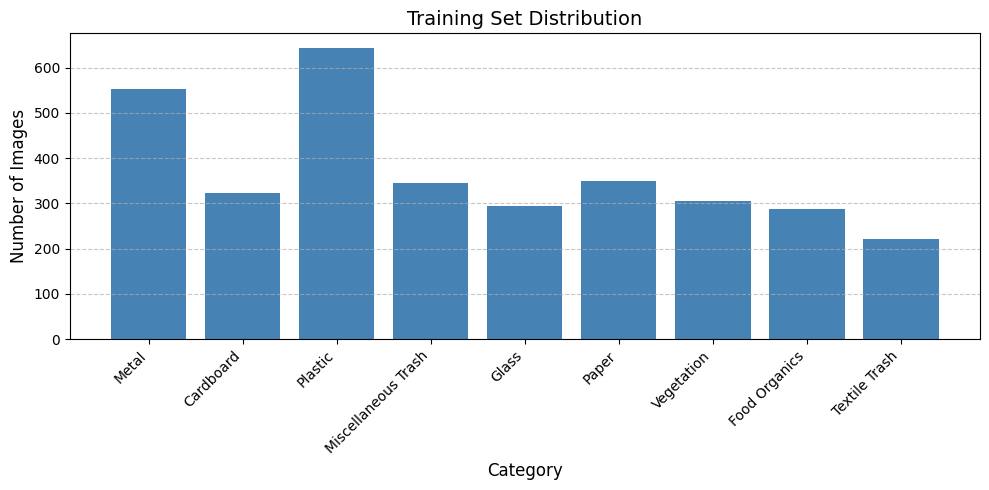

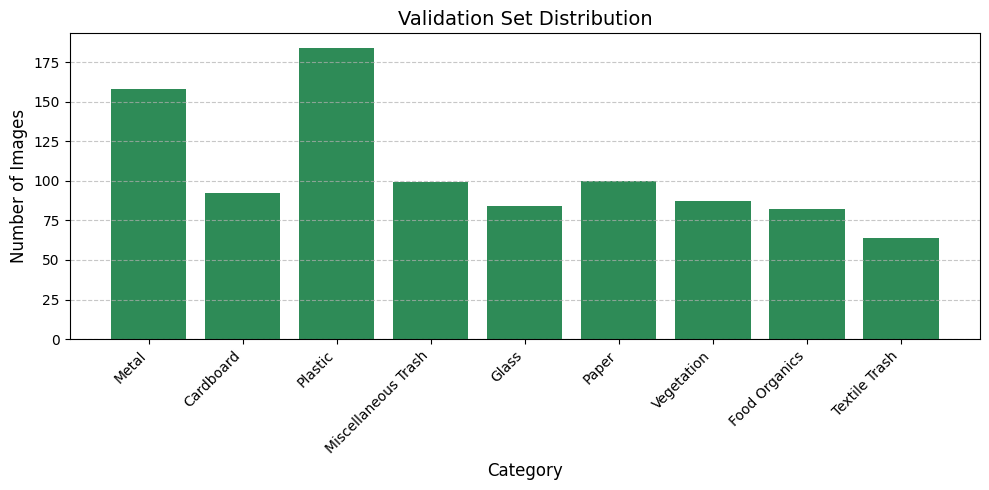

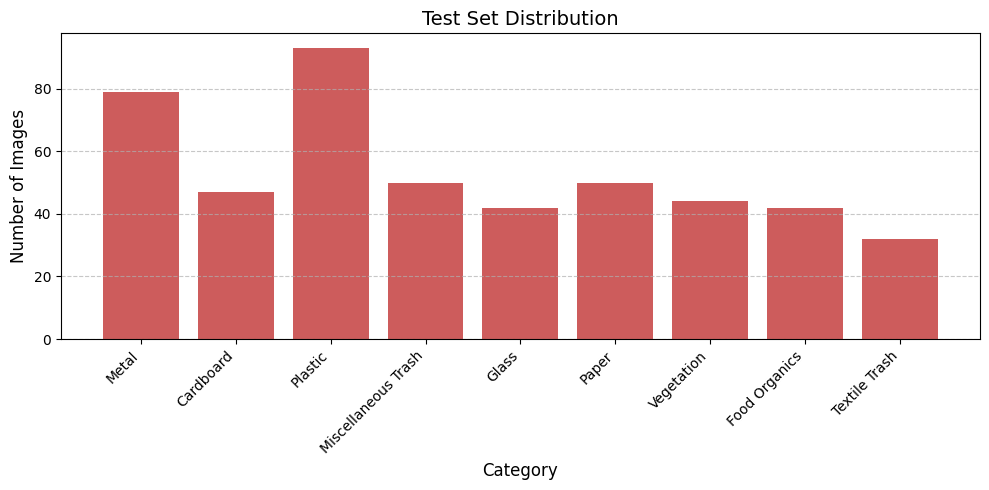

In [8]:
# ==========================================================
# 5. VISUALIZE DISTRIBUTION FOR TRAIN / VALIDATION / TEST
# ==========================================================
# Count number of images per class in each split (using existing folders)
train_counts = {cls: len(os.listdir(os.path.join(base_dir, 'train', cls))) for cls in os.listdir(os.path.join(base_dir, 'train'))}
val_counts = {cls: len(os.listdir(os.path.join(base_dir, 'val', cls))) for cls in os.listdir(os.path.join(base_dir, 'val'))}
test_counts = {cls: len(os.listdir(os.path.join(base_dir, 'test', cls))) for cls in os.listdir(os.path.join(base_dir, 'test'))}

# Convert to DataFrames
df_train = pd.DataFrame(list(train_counts.items()), columns=['Category', 'Count'])
df_val = pd.DataFrame(list(val_counts.items()), columns=['Category', 'Count'])
df_test = pd.DataFrame(list(test_counts.items()), columns=['Category', 'Count'])

# -----------------------------
# Plot: Training Set
# -----------------------------
plt.figure(figsize=(10,5))
plt.bar(df_train['Category'], df_train['Count'], color='steelblue')
plt.title('Training Set Distribution', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot: Validation Set
# -----------------------------
plt.figure(figsize=(10,5))
plt.bar(df_val['Category'], df_val['Count'], color='seagreen')
plt.title('Validation Set Distribution', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot: Test Set
# -----------------------------
plt.figure(figsize=(10,5))
plt.bar(df_test['Category'], df_test['Count'], color='indianred')
plt.title('Test Set Distribution', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

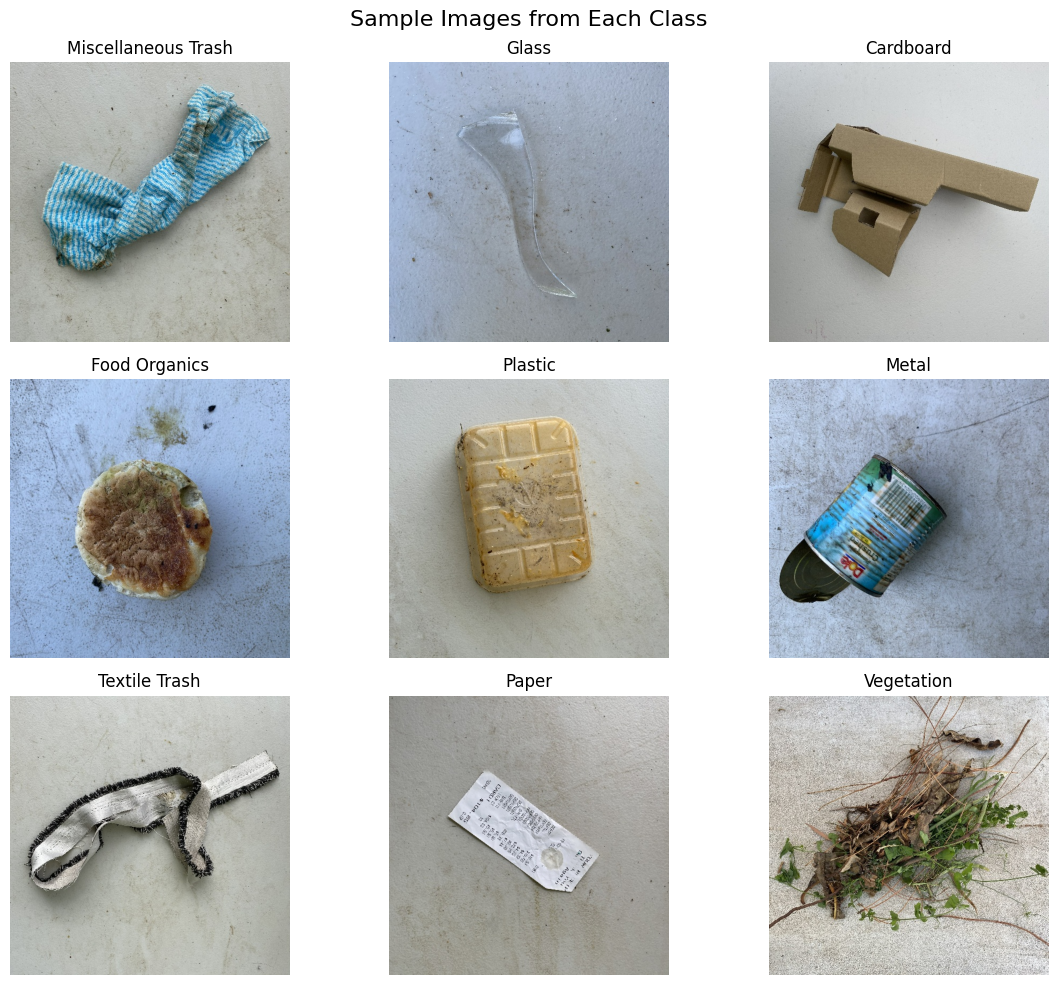

In [9]:
# -----------------------------
# 3️⃣ Example Images per Class
# -----------------------------
from PIL import Image
plt.figure(figsize=(12, 10))
for i, cls in enumerate(classes[:9]):  # show up to 9 classes
    class_folder = os.path.join(data_dir, cls)
    sample_img = os.listdir(class_folder)[0]
    img_path = os.path.join(class_folder, sample_img)
    img = Image.open(img_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()


🖼️ Average Image Size: 524.0 x 524.0
Aspect Ratio Range: 1.00–1.00


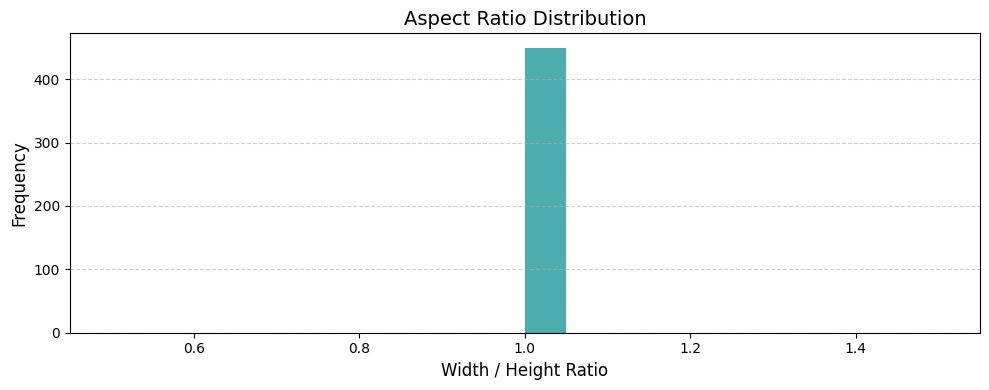

In [10]:
# -----------------------------
# 4️⃣ Image Size & Aspect Ratio Analysis
# -----------------------------
widths, heights = [], []
for cls in classes:
    class_folder = os.path.join(data_dir, cls)
    for img_name in os.listdir(class_folder)[:50]:  # sample up to 50 per class
        img_path = os.path.join(class_folder, img_name)
        try:
            img = Image.open(img_path)
            widths.append(img.width)
            heights.append(img.height)
        except:
            continue

widths, heights = np.array(widths), np.array(heights)
aspect_ratios = widths / heights

print(f"\n🖼️ Average Image Size: {np.mean(widths):.1f} x {np.mean(heights):.1f}")
print(f"Aspect Ratio Range: {aspect_ratios.min():.2f}–{aspect_ratios.max():.2f}")

plt.figure(figsize=(10,4))
plt.hist(aspect_ratios, bins=20, color='darkcyan', alpha=0.7)
plt.title("Aspect Ratio Distribution", fontsize=14)
plt.xlabel("Width / Height Ratio", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

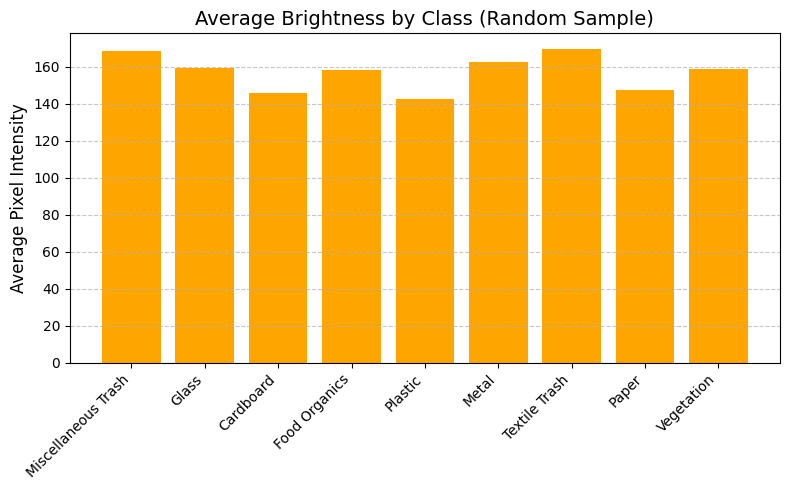

In [11]:
# -----------------------------
# 5️⃣ Pixel Intensity Distribution (Random Sample)
# -----------------------------
sample_paths = []
for cls in classes:
    class_folder = os.path.join(data_dir, cls)
    sample_paths.append(os.path.join(class_folder, np.random.choice(os.listdir(class_folder))))

# Compute brightness
brightness = []
for path in sample_paths:
    img = Image.open(path).convert('L')  # grayscale
    brightness.append(np.mean(np.array(img)))

plt.figure(figsize=(8,5))
plt.bar(classes, brightness, color='orange')
plt.title("Average Brightness by Class (Random Sample)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Pixel Intensity", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
# ==========================================================
# 6. CHECK LABEL INFORMATION
# ==========================================================
# 1️⃣ Check the class-to-index mapping
print("\n📚 Class indices mapping (label name → numeric ID):")
print(train_generator.class_indices)

# 2️⃣ Get numeric labels assigned to each training image
train_labels = train_generator.classes
val_labels = val_generator.classes
test_labels = test_generator.classes

# 3️⃣ Display summary information
print("\n🔢 Label array shapes:")
print(f"Train labels: {train_labels.shape}")
print(f"Validation labels: {val_labels.shape}")
print(f"Test labels: {test_labels.shape}")

# 4️⃣ Check unique class values and counts
unique_train, counts_train = np.unique(train_labels, return_counts=True)
unique_val, counts_val = np.unique(val_labels, return_counts=True)
unique_test, counts_test = np.unique(test_labels, return_counts=True)

print("\n📊 Label distribution (per class index):")
print("Train:", dict(zip(unique_train, counts_train)))
print("Validation:", dict(zip(unique_val, counts_val)))
print("Test:", dict(zip(unique_test, counts_test)))


📚 Class indices mapping (label name → numeric ID):
{'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}

🔢 Label array shapes:
Train labels: (3323,)
Validation labels: (950,)
Test labels: (479,)

📊 Label distribution (per class index):
Train: {np.int32(0): np.int64(322), np.int32(1): np.int64(287), np.int32(2): np.int64(294), np.int32(3): np.int64(553), np.int32(4): np.int64(346), np.int32(5): np.int64(350), np.int32(6): np.int64(644), np.int32(7): np.int64(222), np.int32(8): np.int64(305)}
Validation: {np.int32(0): np.int64(92), np.int32(1): np.int64(82), np.int32(2): np.int64(84), np.int32(3): np.int64(158), np.int32(4): np.int64(99), np.int32(5): np.int64(100), np.int32(6): np.int64(184), np.int32(7): np.int64(64), np.int32(8): np.int64(87)}
Test: {np.int32(0): np.int64(47), np.int32(1): np.int64(42), np.int32(2): np.int64(42), np.int32(3): np.int64(79), np.int32(4): np.int64(50), np.in

In [13]:
!pip install tensorflowjs

In [14]:
# ==========================================================
# 7. MODEL BUILDING, COMPILATION, AND TRAINING
# ==========================================================
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import ydf

# -----------------------------
# 1️⃣ Build CNN Model
# -----------------------------
model = Sequential([
    # Convolutional Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    # Convolutional Block 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    # Convolutional Block 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer
])

In [15]:
# -----------------------------
# 2️⃣ Compile Model
# -----------------------------
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,247,881 (84.87 MB)

 Trainable params: 22,247,433 (84.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
# -----------------------------
# 3️⃣ Define Callbacks
# -----------------------------
import os
from google.colab import drive

# --- Mount to Google Drive ---
drive.mount("/content/drive", force_remount=True)

# --- Define the custom output path ---
output_dir = '/content/drive/MyDrive/Colab Notebooks/RealWaste_Testing/Resources/Models/' #/content/drive/My Drive/Colab Notebooks/RealWaste_Testing
keras_model_path = os.path.join(output_dir, 'best_cnn_model.keras')


callbacks = [
    # 1️⃣ Reduce learning rate when validation accuracy plateaus
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',   # Monitor validation accuracy
        factor=0.5,               # Reduce learning rate by half
        patience=4,               # Wait 4 epochs with no improvement
        min_lr=1e-5,              # Do not reduce below this value
        verbose=1
    ),

    # 2️⃣ Stop training when validation accuracy stops improving
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',   # Monitor validation accuracy
        mode='max',               # We want to maximize accuracy
        patience=10,              # Wait 10 epochs before stopping
        restore_best_weights=True,# Restore best model weights
        verbose=1
    ),

    # 3️⃣ Save best model automatically
    keras.callbacks.ModelCheckpoint(
        filepath=keras_model_path,  # Updated filename to match your current CNN workflow
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,      # Save only the best model
        verbose=1
    ),

    # 4️⃣ Stop training if NaN loss is encountered
    keras.callbacks.TerminateOnNaN()
]

Mounted at /content/drive


In [17]:
# -----------------------------
# 4️⃣Train Model (with callbacks)
# -----------------------------
epochs = 30  # early stopping will stop before this if needed

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3638 - loss: 3.5304
Epoch 1: val_accuracy improved from -inf to 0.09263, saving model to /content/drive/MyDrive/Colab Notebooks/RealWaste_Testing/Resources/Models/best_cnn_model.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 490s 5s/step - accuracy: 0.3643 - loss: 3.5218 - val_accuracy: 0.0926 - val_loss: 3.1027 - learning_rate: 1.0000e-04
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5896 - loss: 1.2236
Epoch 2: val_accuracy did not improve from 0.09263
104/104 ━━━━━━━━━━━━━━━━━━━━ 484s 5s/step - accuracy: 0.5895 - loss: 1.2234 - val_accuracy: 0.0884 - val_loss: 5.2217 - learning_rate: 1.0000e-04
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7080 - loss: 0.8533
Epoch 3: val_accuracy improved from 0.09263 to 0.09789, saving model to /content/drive/MyDrive/Colab Notebooks/RealWaste_Testing/Resources/Models/best_cnn_model.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 486s 5s/step - accuracy: 0.7080 - loss: 0.

### Convert Tensorflow light Model for Web Application deployment

In [18]:
!pip install tensorflowjs tflite

In [19]:
# -----------------------------------------
# Convert Trained Model to TFLite format
# ----------------------------------------
import tensorflow as tf
import os

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print("Model conversion to TFLite format complete.")

# ----------------------------------------------------------
# Save to a Different Location (Persistent Google Drive)
# ----------------------------------------------------------
import os
from google.colab import drive

# --- 1. Mount to Google Drive ---
drive.mount("/content/drive", force_remount=True)

# --- 2. Define the custom output path ---
output_dir = '/content/drive/MyDrive/Colab Notebooks/RealWaste_Testing/Resources/Models/' # Change to preferred output location!
tflite_model_path = os.path.join(output_dir, 'real_waste_cnn_model.tflite')

# --- 3. Create the directory if it doesn't exist ---
# This is a crucial step to avoid "File not found" errors
os.makedirs(output_dir, exist_ok=True)

# --- 4. Write the model to your Google Drive path ---
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model)

print(f"Model saved to Google Drive: {tflite_model_path}")

Saved artifact at '/tmp/tmpqwsiwb_k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  137789428882064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789428885328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789428883216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789428885520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789428883408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789428884752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789428883792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789428886288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789428886480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789428887248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13778942888705

In [20]:
# ----------------------------------------------------------
# Save trained model to .h5 format and saved model format (weighted bins)
# ----------------------------------------------------------
import os
from google.colab import drive

# --- 1. Mount to Google Drive ---
drive.mount("/content/drive", force_remount=True)

# --- 2. Define the custom output path ---
output_dir = '/content/drive/MyDrive/Colab Notebooks/RealWaste_Testing/Resources/Models/' #/content/drive/My Drive/Colab Notebooks/RealWaste_Testing
keras_model_path = os.path.join(output_dir, 'real_waste_cnn_model.keras')

tfjs.converters.save_keras_model(model, keras_model_path)
print("✅ Model training complete and saved as .keras format.")

# # ----------------------------------------------------------
# # Save trained model to .h5 format
# # ----------------------------------------------------------
# h5_model_path = os.path.join(output_dir, 'realwaste_cnn_model_revised.h5')
# print(h5_model_path)
# model.save("h5_model_path")
# print("✅ Model training complete and saved as .h5 format.")

Mounted at /content/drive
failed to lookup keras version from the file,
    this is likely a weight only file
✅ Model training complete and saved as .keras format.


In [21]:
# ==========================================================
# 9. TRAINING HISTORY SUMMARY AND VISUALIZATION
# ==========================================================
# Retrieve training history
H = history.history
epochs = np.arange(1, len(H["loss"]) + 1)

# -----------------------------
# 1️⃣ Print Summary of Final Epoch
# -----------------------------
print("\n📊 Final Epoch Results:")
print(f"  Train Accuracy : {H['accuracy'][-1]:.4f}")
print(f"  Val Accuracy   : {H['val_accuracy'][-1]:.4f}")
print(f"  Train Loss     : {H['loss'][-1]:.4f}")
print(f"  Val Loss       : {H['val_loss'][-1]:.4f}")

# Check if learning rate was logged by callback
if "lr" in H:
    print(f"  Learning Rate  : {H['lr'][-1]:.6g}")
elif "learning_rate" in H:
    print(f"  Learning Rate  : {H['learning_rate'][-1]:.6g}")


📊 Final Epoch Results:
  Train Accuracy : 0.9964
  Val Accuracy   : 0.7147
  Train Loss     : 0.0158
  Val Loss       : 1.1597
  Learning Rate  : 2.5e-05


In [22]:
# -----------------------------
# 2️⃣ Identify Best Epochs
# -----------------------------
best_va_ep = int(np.nanargmax(H["val_accuracy"])) + 1
best_vl_ep = int(np.nanargmin(H["val_loss"])) + 1

print("\n🏆 Best Epochs:")
print(f"  Best val_accuracy at epoch {best_va_ep}: {H['val_accuracy'][best_va_ep-1]:.4f}")
print(f"  Best val_loss     at epoch {best_vl_ep}: {H['val_loss'][best_vl_ep-1]:.4f}")



🏆 Best Epochs:
  Best val_accuracy at epoch 29: 0.7316
  Best val_loss     at epoch 7: 1.0666


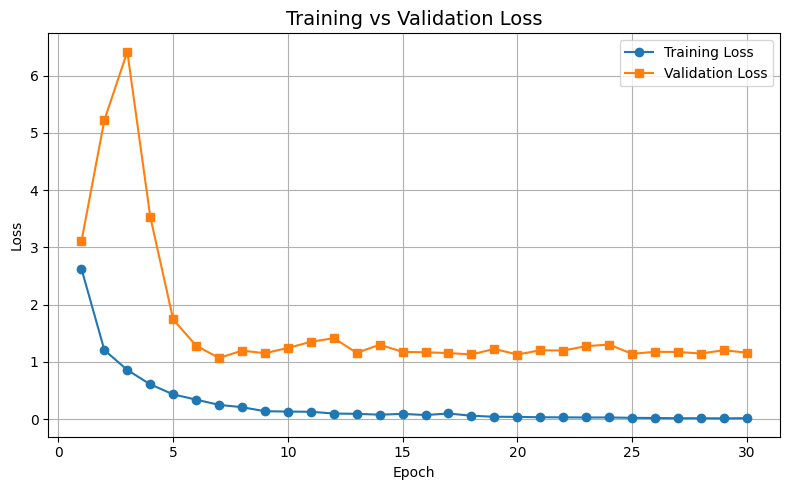

In [23]:
# -----------------------------
# 3️⃣ Plot: Training vs Validation Loss
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, H["loss"], label="Training Loss", marker='o')
plt.plot(epochs, H["val_loss"], label="Validation Loss", marker='s')
plt.title("Training vs Validation Loss", fontsize=14)
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

In [41]:
import json

# Extract data for charts
epochs = np.arange(1, len(H["loss"]) + 1).tolist()
train_loss = H["loss"]
val_loss = H["val_loss"]

# Create JSON object for Chart.js
chart_data = {
    "labels": epochs,
    "datasets": [
        {
            "label": "Training Loss",
            "data": train_loss,
            "borderColor": "steelblue",
            "fill": False
        },
        {
            "label": "Validation Loss",
            "data": val_loss,
            "borderColor": "seagreen",
            "fill": False
        }
    ]
}

# Convert to JSON string
Training_vs_Validation_Loss_json_string = json.dumps(chart_data, indent=4)

# Print or save the JSON
print(Training_vs_Validation_Loss_json_string)


JSON_dir = '/content/drive/MyDrive/Colab Notebooks/RealWaste_Testing/Resources/Charts_JSON/' #/content/drive/My Drive/Colab Notebooks/RealWaste_Testing
Training_vs_Validation_Loss_json_path = os.path.join(JSON_dir, 'Training_vs_Validation_Loss_data.json')

# Save this to a json file:
with open(Training_vs_Validation_Loss_json_path, 'w') as f:
    f.write(Training_vs_Validation_Loss_json_string)

{
    "labels": [
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        26,
        27,
        28,
        29,
        30
    ],
    "datasets": [
        {
            "label": "Training Loss",
            "data": [
                2.6283364295959473,
                1.2056530714035034,
                0.8574649095535278,
                0.6057311296463013,
                0.43157386779785156,
                0.3390868902206421,
                0.24820156395435333,
                0.20717602968215942,
                0.1368597000837326,
                0.1306908279657364,
                0.127074733376503,
                0.09636637568473816,
                0.09132412075996399,
                0.07636807858943939,
                0.0902274027

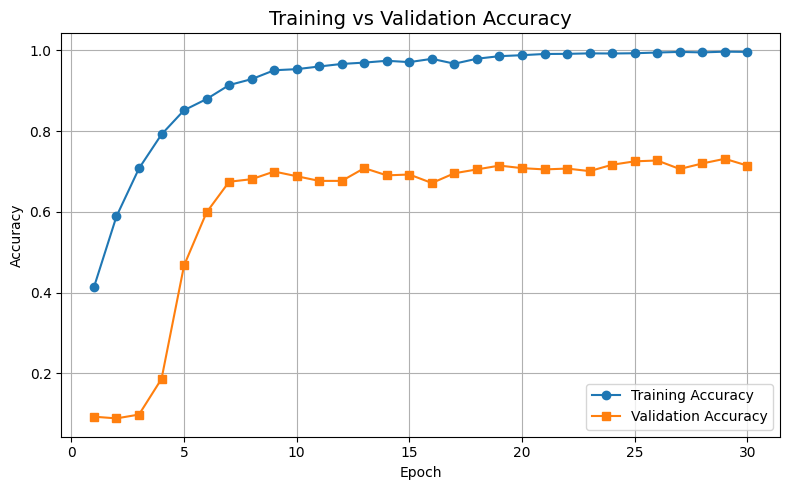

In [24]:
# -----------------------------
# 4️⃣ Plot: Training vs Validation Accuracy
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, H["accuracy"], label="Training Accuracy", marker='o')
plt.plot(epochs, H["val_accuracy"], label="Validation Accuracy", marker='s')
plt.title("Training vs Validation Accuracy", fontsize=14)
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


In [42]:
import json

# Extract data for charts
epochs = np.arange(1, len(H["loss"]) + 1).tolist()
train_accuracy = H["accuracy"]
val_accuracy = H["val_accuracy"]

# Create JSON object for Chart.js
chart_data = {
    "labels": epochs,
    "datasets": [
        {
            "label": "Training Accuracy",
            "data": train_accuracy,
            "borderColor": "orange",
            "fill": False
        },
        {
            "label": "Validation Accuracy",
            "data": val_accuracy,
            "borderColor": "indianred",
            "fill": False
        }
    ]
}

# Convert to JSON string
Training_vs_Validation_Accuracy_json_string = json.dumps(chart_data, indent=4)

# Print or save the JSON
print(Training_vs_Validation_Accuracy_json_string)

JSON_dir = '/content/drive/MyDrive/Colab Notebooks/RealWaste_Testing/Resources/Charts_JSON/' #/content/drive/My Drive/Colab Notebooks/RealWaste_Testing
Training_vs_Validation_Accuracy_json_path = os.path.join(JSON_dir, 'Training_vs_Validation_Accuracy_data.json')

# Save this to a json file:
with open(Training_vs_Validation_Accuracy_json_path, 'w') as f:
    f.write(Training_vs_Validation_Accuracy_json_string)


{
    "labels": [
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        26,
        27,
        28,
        29,
        30
    ],
    "datasets": [
        {
            "label": "Training Accuracy",
            "data": [
                0.41348180174827576,
                0.5889256596565247,
                0.707794189453125,
                0.7920553684234619,
                0.8519409894943237,
                0.8796268701553345,
                0.9142341017723083,
                0.9289798140525818,
                0.9509479403495789,
                0.9536563158035278,
                0.9602768421173096,
                0.9665964245796204,
                0.9699066877365112,
                0.9744207262992859,
                0.97111046314

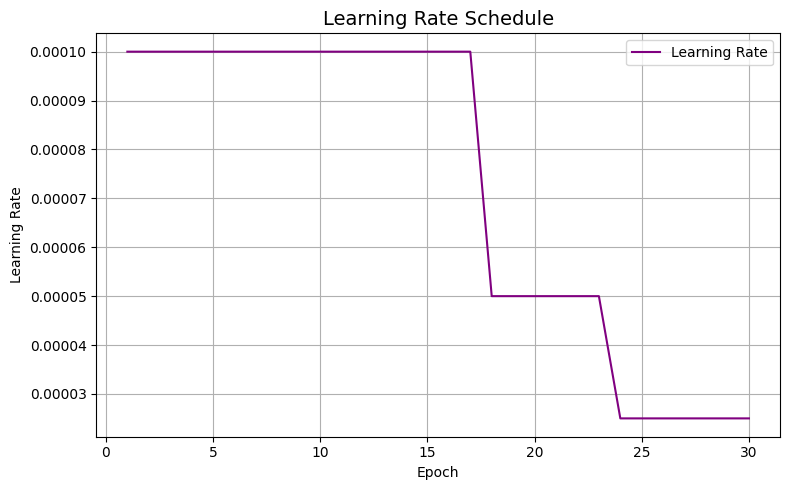

In [44]:
# -----------------------------
# 5️⃣ (Optional) Plot: Learning Rate Schedule
# -----------------------------
if "lr" in H or "learning_rate" in H:
    lr_key = "lr" if "lr" in H else "learning_rate"
    plt.figure(figsize=(8,5))
    plt.plot(epochs, H[lr_key], label="Learning Rate", color='purple')
    plt.title("Learning Rate Schedule", fontsize=14)
    plt.xlabel("Epoch"); plt.ylabel("Learning Rate")
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.show()

In [45]:
import json

# Extract data for learning rate plot
epochs = np.arange(1, len(H["loss"]) + 1).tolist()
lr_key = "lr" if "lr" in H else "learning_rate"
learning_rate = H[lr_key]

# Create JSON object for Chart.js
learning_rate_json = {
    "labels": epochs,
    "datasets": [
        {
            "label": "Learning Rate",
            "data": learning_rate,
            "borderColor": "purple",
            "fill": False
        }
    ]
}

# Convert to JSON string
learning_rate_json_string = json.dumps(learning_rate_json, indent=4)

# Print or save the JSON
print(learning_rate_json_string)

JSON_dir = '/content/drive/MyDrive/Colab Notebooks/RealWaste_Testing/Resources/Charts_JSON/' #/content/drive/My Drive/Colab Notebooks/RealWaste_Testing
learning_rate_json_path = os.path.join(JSON_dir, 'learning_rate_data.json')

# Save this to a json file:
with open(learning_rate_json_path, 'w') as f:
    f.write(learning_rate_json_string)

{
    "labels": [
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        26,
        27,
        28,
        29,
        30
    ],
    "datasets": [
        {
            "label": "Learning Rate",
            "data": [
                9.999999747378752e-05,
                9.999999747378752e-05,
                9.999999747378752e-05,
                9.999999747378752e-05,
                9.999999747378752e-05,
                9.999999747378752e-05,
                9.999999747378752e-05,
                9.999999747378752e-05,
                9.999999747378752e-05,
                9.999999747378752e-05,
                9.999999747378752e-05,
                9.999999747378752e-05,
                9.999999747378752e-05,
                9.999999747378

In [26]:
# ==========================================================
# 10. MODEL EVALUATION AND PERFORMANCE ANALYSIS ( using TensorFlow Lite model file)
# ==========================================================
import os
import numpy as np
import tensorflow as tf
from google.colab import drive

# --- 1. Mount to Google Drive ---
drive.mount('/content/drive')
output_dir = '/content/drive/MyDrive/Colab Notebooks/RealWaste_Testing/Resources/Models/' #/content/drive/My Drive/Colab Notebooks/RealWaste_Testing
tflite_model_path = os.path.join(output_dir, 'real_waste_cnn_model.tflite')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)

# Allocate tensors
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare input data (example: random data matching input shape)
input_shape = input_details[0]['shape']
input_data = np.random.random_sample(input_shape).astype(np.float32)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get the output tensor
model_output = interpreter.get_tensor(output_details[0]['index'])
print("✅ Best model loaded successfully. Output: ", model_output)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Best model loaded successfully. Output:  [[6.6684211e-18 5.5719843e-21 8.5807199e-36 3.4923593e-27 3.9685780e-20
  7.6909816e-19 2.6954648e-35 3.8037800e-29 1.0000000e+00]]


In [27]:
# ==========================================================
# 10. MODEL EVALUATION AND PERFORMANCE ANALYSIS
# ==========================================================
from tensorflow.keras.models import load_model
from tensorflow import keras
from keras.models import model_from_json
import tensorflowjs as tfjs
import os
# -----------------------------
# 1️⃣ Load the best saved model
# -----------------------------
from google.colab import drive

# --- 1. Mount to Google Drive ---
drive.mount("/content/drive", force_remount=True)
output_dir = '/content/drive/MyDrive/Colab Notebooks/RealWaste_Testing/Resources/Models/' #/content/drive/My Drive/Colab Notebooks/RealWaste_Testing
model_path = os.path.join(output_dir, 'realwaste_cnn_model_revised.keras')

best_model = load_model(model_path)
print("✅ Best model loaded successfully.")

Mounted at /content/drive
✅ Best model loaded successfully.


In [28]:
# -----------------------------
# 2️⃣ Evaluate on Test Set
# -----------------------------
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)
print(f"\n📊 Test Accuracy: {test_accuracy:.4f}")
print(f"🧮 Test Loss: {test_loss:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9177 - loss: 0.3320

📊 Test Accuracy: 0.9186
🧮 Test Loss: 0.3497


In [29]:
# -----------------------------
# 3️⃣ Generate Predictions
# -----------------------------
# Get true labels and predicted probabilities
y_true = test_generator.classes
y_pred_prob = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step


In [30]:
# -----------------------------
# 4️⃣ Classification Report
# -----------------------------
target_names = list(test_generator.class_indices.keys())
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


📋 Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.93      0.89      0.91        47
      Food Organics       0.95      0.95      0.95        42
              Glass       0.91      0.98      0.94        42
              Metal       0.90      0.91      0.91        79
Miscellaneous Trash       0.92      0.88      0.90        50
              Paper       0.94      0.92      0.93        50
            Plastic       0.90      0.90      0.90        93
      Textile Trash       0.91      0.91      0.91        32
         Vegetation       0.93      0.95      0.94        44

           accuracy                           0.92       479
          macro avg       0.92      0.92      0.92       479
       weighted avg       0.92      0.92      0.92       479



<Figure size 1100x800 with 0 Axes>

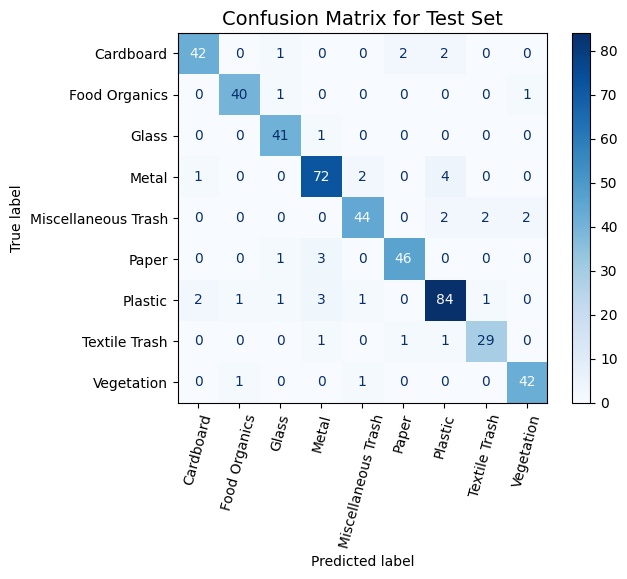

In [31]:
# -----------------------------
# 5️⃣ Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

plt.figure(figsize=(11,8))
disp.plot(cmap='Blues', xticks_rotation=75, values_format='d')
plt.title("Confusion Matrix for Test Set", fontsize=14)
plt.grid(False)
plt.show()

In [46]:
import json

# Get confusion matrix data and labels
cm_data = cm.tolist()  # Convert numpy array to list for JSON serialization
labels = target_names

# Create JSON object for the confusion matrix
confusion_matrix_json = {
    "labels": labels,
    "matrix": cm_data
}

# Convert to JSON string
confusion_matrix_json_string = json.dumps(confusion_matrix_json, indent=4)

# Print or save the JSON
print(confusion_matrix_json_string)

JSON_dir = '/content/drive/MyDrive/Colab Notebooks/RealWaste_Testing/Resources/Charts_JSON/' #/content/drive/My Drive/Colab Notebooks/RealWaste_Testing
confusion_matrix_json_path = os.path.join(JSON_dir, 'confusion_matrix_data.json')

# You can also save this to a file:
with open(confusion_matrix_json_path, 'w') as f:
    f.write(confusion_matrix_json_string)

{
    "labels": [
        "Cardboard",
        "Food Organics",
        "Glass",
        "Metal",
        "Miscellaneous Trash",
        "Paper",
        "Plastic",
        "Textile Trash",
        "Vegetation"
    ],
    "matrix": [
        [
            42,
            0,
            1,
            0,
            0,
            2,
            2,
            0,
            0
        ],
        [
            0,
            40,
            1,
            0,
            0,
            0,
            0,
            0,
            1
        ],
        [
            0,
            0,
            41,
            1,
            0,
            0,
            0,
            0,
            0
        ],
        [
            1,
            0,
            0,
            72,
            2,
            0,
            4,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            44,
            0,
            2,
            2,
           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


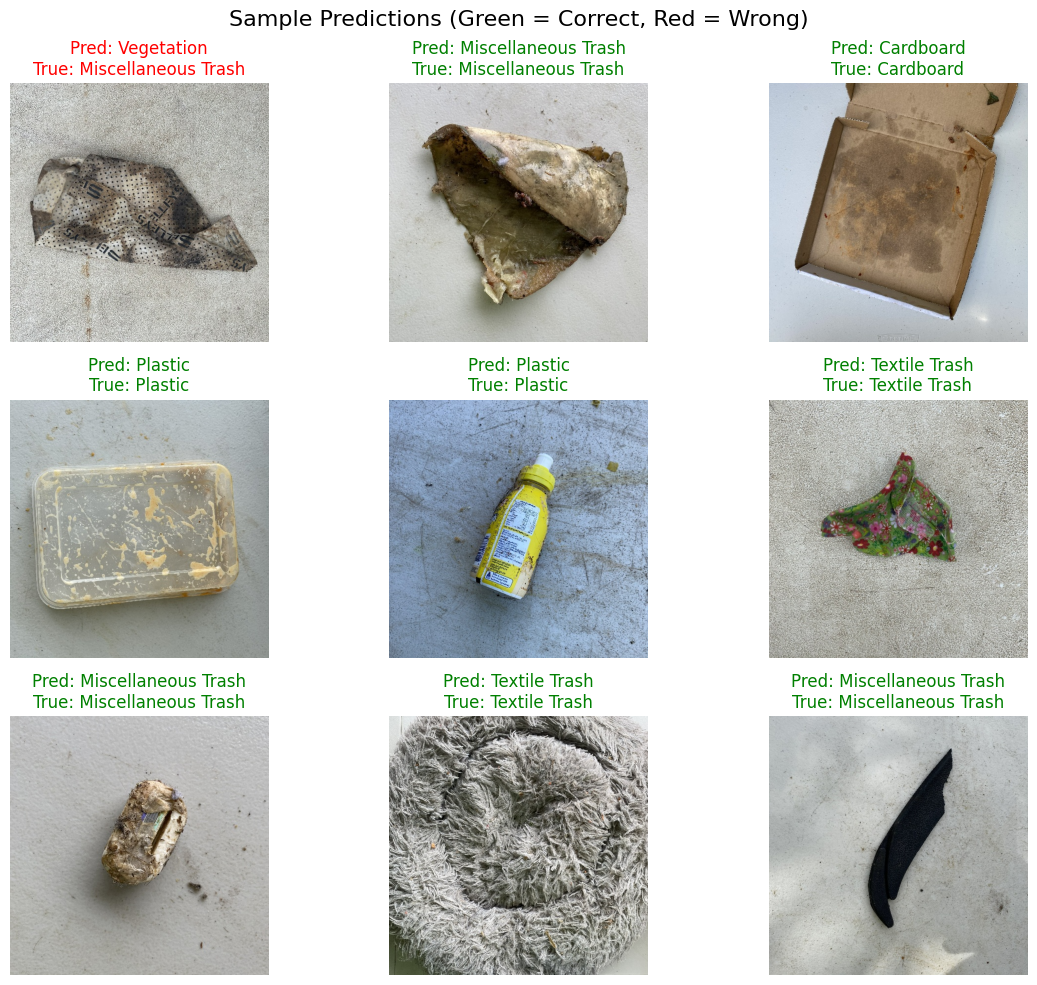

In [47]:
# -----------------------------
# 6️⃣ Visualize Correct vs Misclassified Samples
# -----------------------------
import random
from tensorflow.keras.preprocessing import image

# Get file paths from test set
test_files = test_generator.filepaths

# Randomly sample 9 test images
plt.figure(figsize=(12,10))
for i in range(9):
    idx = random.randint(0, len(test_files) - 1)
    img_path = test_files[idx]
    img = image.load_img(img_path, target_size=(224,224))
    img_array = np.expand_dims(image.img_to_array(img)/255.0, axis=0)
    pred = np.argmax(best_model.predict(img_array), axis=1)[0]

    plt.subplot(3,3,i+1)
    plt.imshow(image.load_img(img_path))
    color = "green" if pred == y_true[idx] else "red"
    plt.title(f"Pred: {target_names[pred]}\nTrue: {target_names[y_true[idx]]}", color=color)
    plt.axis('off')

plt.suptitle("Sample Predictions (Green = Correct, Red = Wrong)", fontsize=16)
plt.tight_layout()
plt.show()

The converted web model is now saved in the `/content/realwaste_web_model` directory. This directory contains the `model.json` file and weight files needed for deployment in a web browser.